In [1]:
import sys
sys.path.append('../src')
import torch
import matplotlib.pyplot as plt
from utils.constants import norm_hi_median as norm_hi
from utils.constants import norm_lo_median as norm_lo
import segmentation_models_pytorch as smp
import numpy as np
from utils.eval_dataset import SatteliteEvalDataset
import matplotlib.colors as mcolors

/esat/gebo/mli1/conda3/envs/geoinf/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(


In [2]:
architecture = getattr(smp, 'Unet')
model = architecture(
    encoder_name='vgg11_bn',  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights='imagenet',  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=14,  # model output channels (number of classes in your dataset)
)
# model = architecture(
#     encoder_name='mit_b2',  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights='imagenet',  # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=14,  # model output channels (number of classes in your dataset)
# )

model.eval()
# Load the checkpoint
checkpoint_path = "/esat/gebo/mli1/pycharmproj/geoinformed_clean/outputs/models/backup/20230911/arch_Unet_enc_vgg11_bn_train_100x8_val_100x8/model_20230907172449.pth"
# checkpoint_path = "/esat/gebo/mli1/pycharmproj/geoinformed_clean/outputs/models/backup/20230911/arch_Unet_enc_mit_b2_train_100x8_val_100x8/model_20230907160007.pth"

checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)
model.eval()
model.cuda()


Unet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

Building the data dictionary...
(1, 256, 256)
(1, 3, 256, 256)
(1, 1, 256, 256)
(256, 256, 3)
(256, 256)


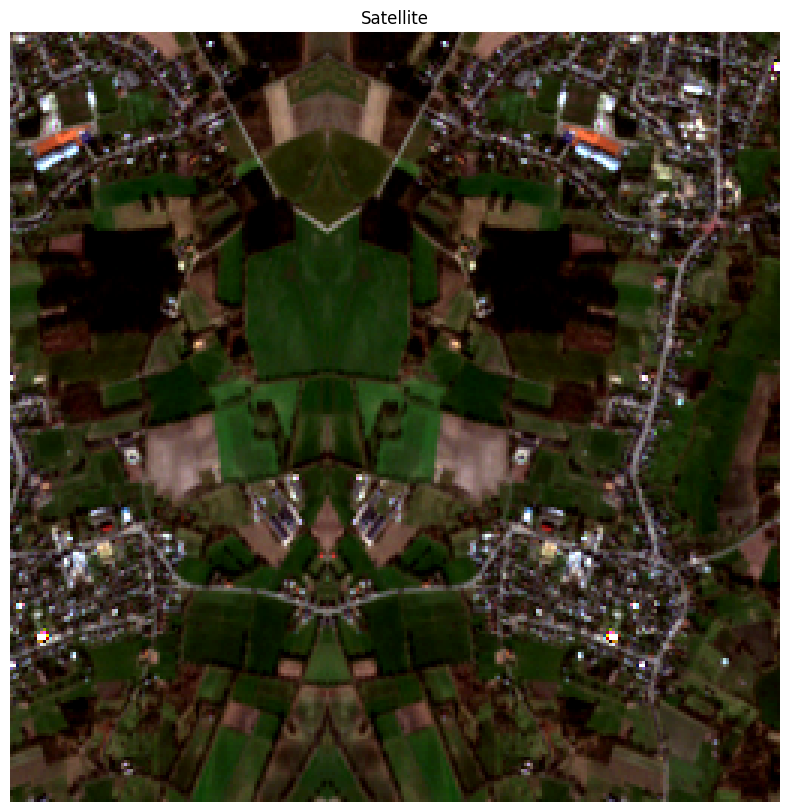

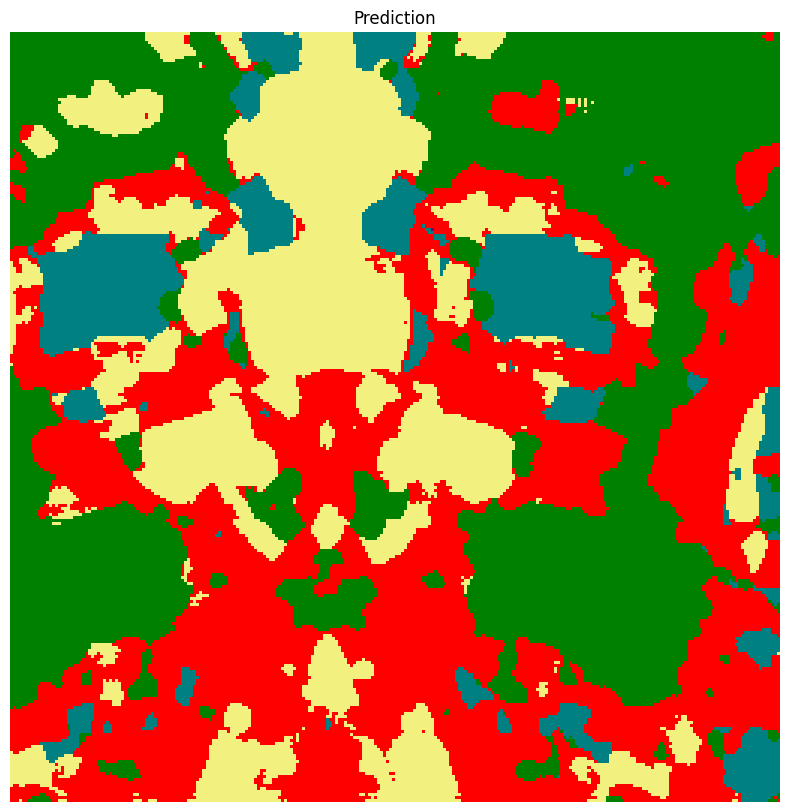

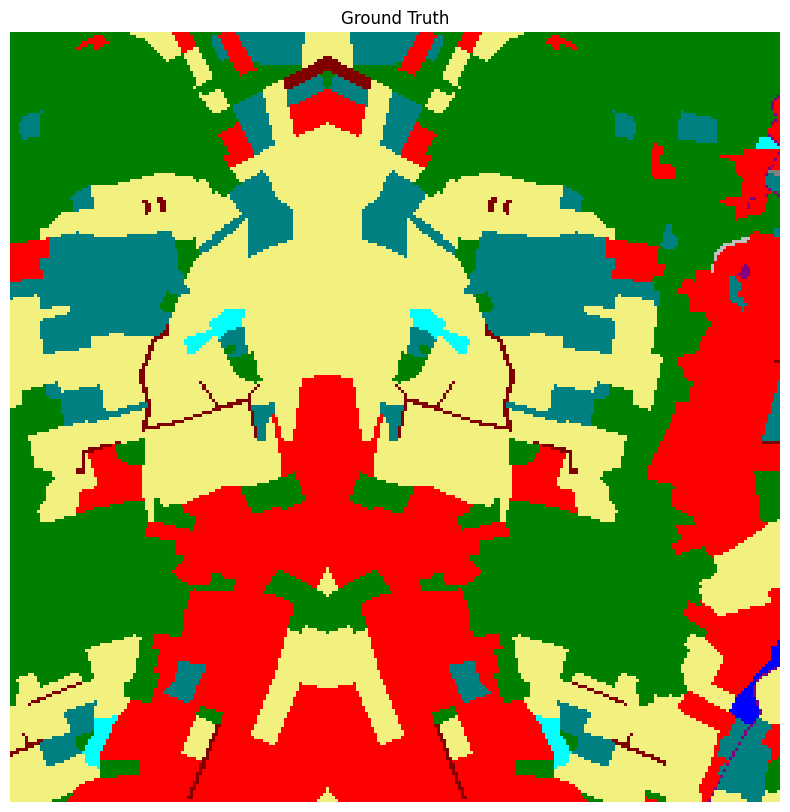

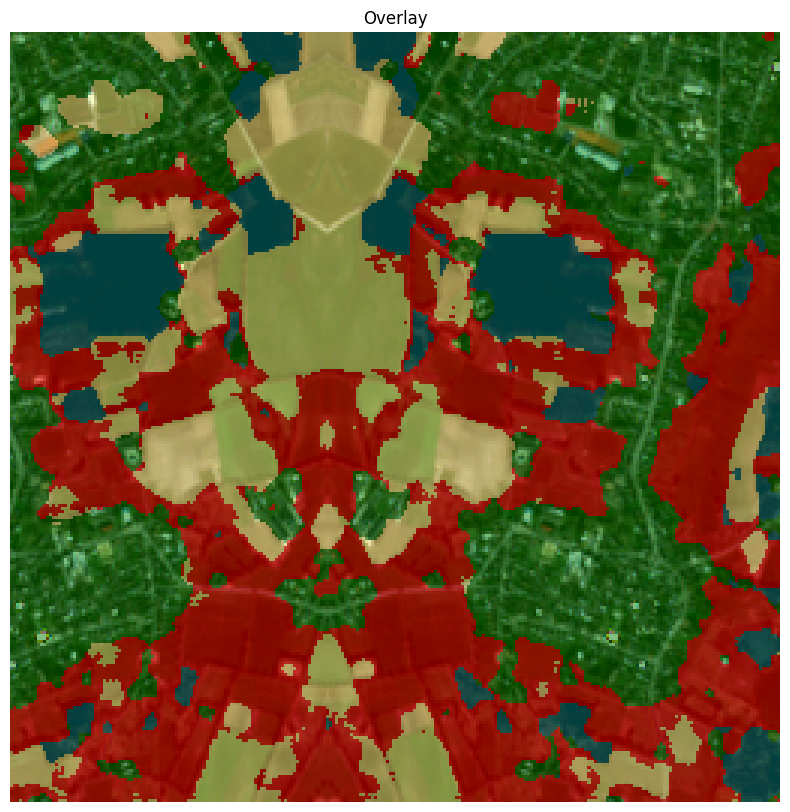

In [95]:
# Your validation dataloader
norm_hi = np.array(norm_hi)
norm_lo = np.array(norm_lo)
vroot_dir = '../downloads_230703'
vkaartbladen = ['17']
vyears = ['2022']
vmonths = ['03']
vpatch_size = 256


val_dataset = SatteliteEvalDataset(
    vroot_dir,
    vkaartbladen,
    vyears,
    vmonths,
    patch_size=vpatch_size,
    norm_hi=norm_hi,
    norm_lo=norm_lo,
    split="val",
    preload_sat_flag=True,
    preload_gt_flag=True,
    preload_cloud_flag=True,
    )
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    num_workers=0,
    shuffle=True
)


    

# Function to display images
def display_image(input_image, title="Satellite"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Show the input image
    ax.imshow(input_image)
    ax.set_title(title)
    ax.axis('off')
    plt.show()


def display_raster(input_image, title="GT"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Show the input image
    
    cmap = mcolors.ListedColormap(
        [
            '#f2f07e', '#FF0000', '#00FF00', '#0000FF',
            '#FFFF00', '#00FFFF', '#FF00FF', '#C0C0C0',
            '#808080', '#800000', '#808000', '#008000',
            '#800080', '#008080'
        ]
    )

    # Show the prediction map overlay with transparency set by alpha
    ax.imshow(input_image, cmap=cmap)

    ax.set_title(title)
    ax.axis('off')
    plt.show()
    
    

def display_overlay(input_image, prediction, alpha=0.5, title="Overlay"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Show the input image
    ax.imshow(input_image, cmap='gray')
    
    cmap = mcolors.ListedColormap(
        [
            '#f2f07e',  # Coastal Dune Habitats
            '#FF0000',  # Cultivated Land
            '#00FF00',  # Grassland
            '#0000FF',  # Heathland
            '#FFFF00',  # Inland Marshes
            '#00FFFF',  # Marine Habitats
            '#FF00FF',  # Pioneer Vegetation
            '#C0C0C0',  # Undefined (small things like roads)
            '#808080',  # Small Non-Wooded Landscape
            '#800000',  # Small Wooded Landscape
            '#808000',  # Unknown
            '#008000',  # Urban Areas
            '#800080',  # Water Bodies
            '#008080'   # Woodland and Shrub
        ]
    )

    # Show the prediction map overlay with transparency set by alpha
    ax.imshow(prediction, cmap=cmap, alpha=alpha)

    ax.set_title(title)
    ax.axis('off')
    plt.show()
    
# Get a sample batch from your dataloader
for i, sample in enumerate(val_dataloader):
    sat = sample['sat']
    gt = sample['gt']
    valid_mask = sample["valid_mask"]
    inputs, labels = sat.cuda(), gt.cuda()  # Move to GPU if available

    # Forward pass
    outputs = model(inputs)
    outputs = torch.softmax(outputs, dim=1)
    predicted = torch.argmax(outputs, dim=1)

    prediction_map = predicted.detach().cpu().numpy()  # Modify this line as needed
    print(prediction_map.shape)
    input_image = inputs.detach().cpu().numpy()  # Modify this line as needed
    print(input_image.shape)
    labels = labels.detach().cpu().numpy()
    print(labels.shape)
    
    # Display overlay
    index = 0
    input_image_0 = np.transpose(input_image[index], (1, 2, 0))
    prediction_0 = prediction_map[index]
    labels_0 = np.transpose(labels[index], (1, 2, 0))
    print(input_image_0.shape)
    print(prediction_0.shape)
    display_image(input_image_0, title="Satellite")
    display_raster(prediction_0, title="Prediction")
    display_raster(labels_0, title="Ground Truth")
    display_overlay(input_image_0, prediction_0, alpha=0.5, title="Overlay")

    if i == 0:  # Stop after the first batch for demonstration
        break

        

In [18]:
# Random stuff for comparison
# Kaartblad 22
# Year: 2022, month: 03, day: 26
# Random coords: 1299, 707